In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from rasterio.plot import show
from matplotlib.ticker import ScalarFormatter
import geopandas as gpd
from shapely.geometry import Point
import cmocean
from pyproj import Transformer
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
from scipy.interpolate import griddata
import utm
import cmocean.cm as cmo

In [32]:
tif_keystone = rasterio.open('Keystonetif.tif')

# dataframe for new dataframe (see judes total_df notebook for addition of polygon location/measurement type and fins big_df notebook for all collected data)
total_df = pd.read_csv('total_df.csv')

# make dataframe for all of keystone measuremnts 
KEY_Full = total_df[total_df['Area'] == 'KEY']
# convert to from UTC to datetime to sort by date
KEY_Full['UTC Time'] = pd.to_datetime(KEY_Full['UTC Time'])
#KEY_Full
# make dataframe of keystone from the 18th
KEY_18 = KEY_Full[KEY_Full['UTC Time'].dt.date == pd.to_datetime('2025-05-18').date()]

#xarray = KEY_18.to_xarray()

# put lat and lon into easting and northing

utm_coords = [utm.from_latlon(lat, lon) for lat, lon in zip(KEY_18['Latitude'], KEY_18['Longitude'])]

KEY_18['Easting']  = [c[0] for c in utm_coords]
KEY_18['Northing'] = [c[1] for c in utm_coords]

KEY_18

C:\Users\15093\AppData\Local\Temp\ipykernel_29284\95875941.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KEY_Full['UTC Time'] = pd.to_datetime(KEY_Full['UTC Time'])


Unnamed: 0  Pressure (dbar)  Depth (m)  Temperature (°C)  \
2647        2647         0.150000   0.153173         11.130358   
2648        2648         0.450000   0.458888         11.190516   
2649        2649         0.750000   0.764815         11.183543   
2650        2650         1.050000   1.070740         11.139386   
2651        2651         1.350000   1.376664         11.116956   
...          ...              ...        ...               ...   
2796        2796         0.750000   0.764813         11.095460   
2797        2797         1.050000   1.070735         11.054688   
2798        2798         1.350000   1.376655         10.959620   
2799        2799         1.650000   1.682572         10.908201   
2800        2800         1.925392   1.963395         10.917460   

      Conductivity (µS/cm)  Specific Conductance (µS/cm)  Salinity (PSS)  \
2647            312.848145                    432.943602        0.205595   
2648            312.196616                    431.323798        0.204842   
2649            312.638727                    432.017843        0.205175   
2650            312.284655                    432.055843        0.205166   
2651            312.156525                    432.146779        0.205195   
...                    ...                           ...             ...   
2796            311.911028                    432.064072        0.205144   
2797            313.061999                    434.148806        0.206133   
2798            311.792631                    433.531601        0.205774   
2799            311.461150                    433.690826        0.205818   
2800            311.422182                    433.524786        0.205742   

      Sound Velocity (m/s)  Density (kg/m³)   Latitude   Longitude  \
2647           1451.965568       999.756232  40.278164 -106.864994   
2648           1452.201414       999.750815  40.278164 -106.864994   
2649           1452.179773       999.753228  40.278164 -106.864994   
2650           1452.014304       999.759236  40.278164 -106.864994   
2651           1451.932593       999.763006  40.278164 -106.864994   
...                    ...              ...        ...         ...   
2796           1451.839903       999.762334  40.280965 -106.867086   
2797           1451.688397       999.768728  40.280965 -106.867086   
2798           1451.324766       999.779564  40.280965 -106.867086   
2799           1451.130237       999.786219  40.280965 -106.867086   
2800           1451.170478       999.786536  40.280965 -106.867086   

                UTC Time                  File Name Area        Easting  \
2647 2025-05-18 16:47:13  CC2435009_20250518_164713  KEY  341447.871639   
2648 2025-05-18 16:47:13  CC2435009_20250518_164713  KEY  341447.871639   
2649 2025-05-18 16:47:13  CC2435009_20250518_164713  KEY  341447.871639   
2650 2025-05-18 16:47:13  CC2435009_20250518_164713  KEY  341447.871639   
2651 2025-05-18 16:47:13  CC2435009_20250518_164713  KEY  341447.871639   
...                  ...                        ...  ...            ...   
2796 2025-05-18 17:07:02  CC2435009_20250518_170702  KEY  341276.579854   
2797 2025-05-18 17:07:02  CC2435009_20250518_170702  KEY  341276.579854   
2798 2025-05-18 17:07:02  CC2435009_20250518_170702  KEY  341276.579854   
2799 2025-05-18 17:07:02  CC2435009_20250518_170702  KEY  341276.579854   
2800 2025-05-18 17:07:02  CC2435009_20250518_170702  KEY  341276.579854   

          Northing  
2647  4.460300e+06  
2648  4.460300e+06  
2649  4.460300e+06  
2650  4.460300e+06  
2651  4.460300e+06  
...            ...  
2796  4.460615e+06  
2797  4.460615e+06  
2798  4.460615e+06  
2799  4.460615e+06  
2800  4.460615e+06  

[154 rows x 16 columns]

In [33]:
# Find min and max values for easting and northings as well as temp
mins = KEY_18.min()

maxs = KEY_18.max()

print(mins)
print(maxs)

Unnamed: 0                                           2647
Pressure (dbar)                                      0.15
Depth (m)                                        0.153172
Temperature (°C)                                 7.889756
Conductivity (µS/cm)                           291.578897
Specific Conductance (µS/cm)                   428.793328
Salinity (PSS)                                   0.203567
Sound Velocity (m/s)                          1439.132545
Density (kg/m³)                                999.750815
Latitude                                        40.277506
Longitude                                     -106.867086
UTC Time                              2025-05-18 16:47:13
File Name                       CC2435009_20250518_164713
Area                                                  KEY
Easting                                     341276.579854
Northing                                   4460228.185075
dtype: object
Unnamed: 0                                           2800


# Find Transect Line

In [34]:
coeffs = np.polyfit(KEY_18['Longitude'], KEY_18['Latitude'], 1)

slope, intercept = coeffs

In [35]:
# linspace with min and max latitude for points
x = np.linspace(-106.867070, -106.8650, 200) 
y = slope * x + intercept

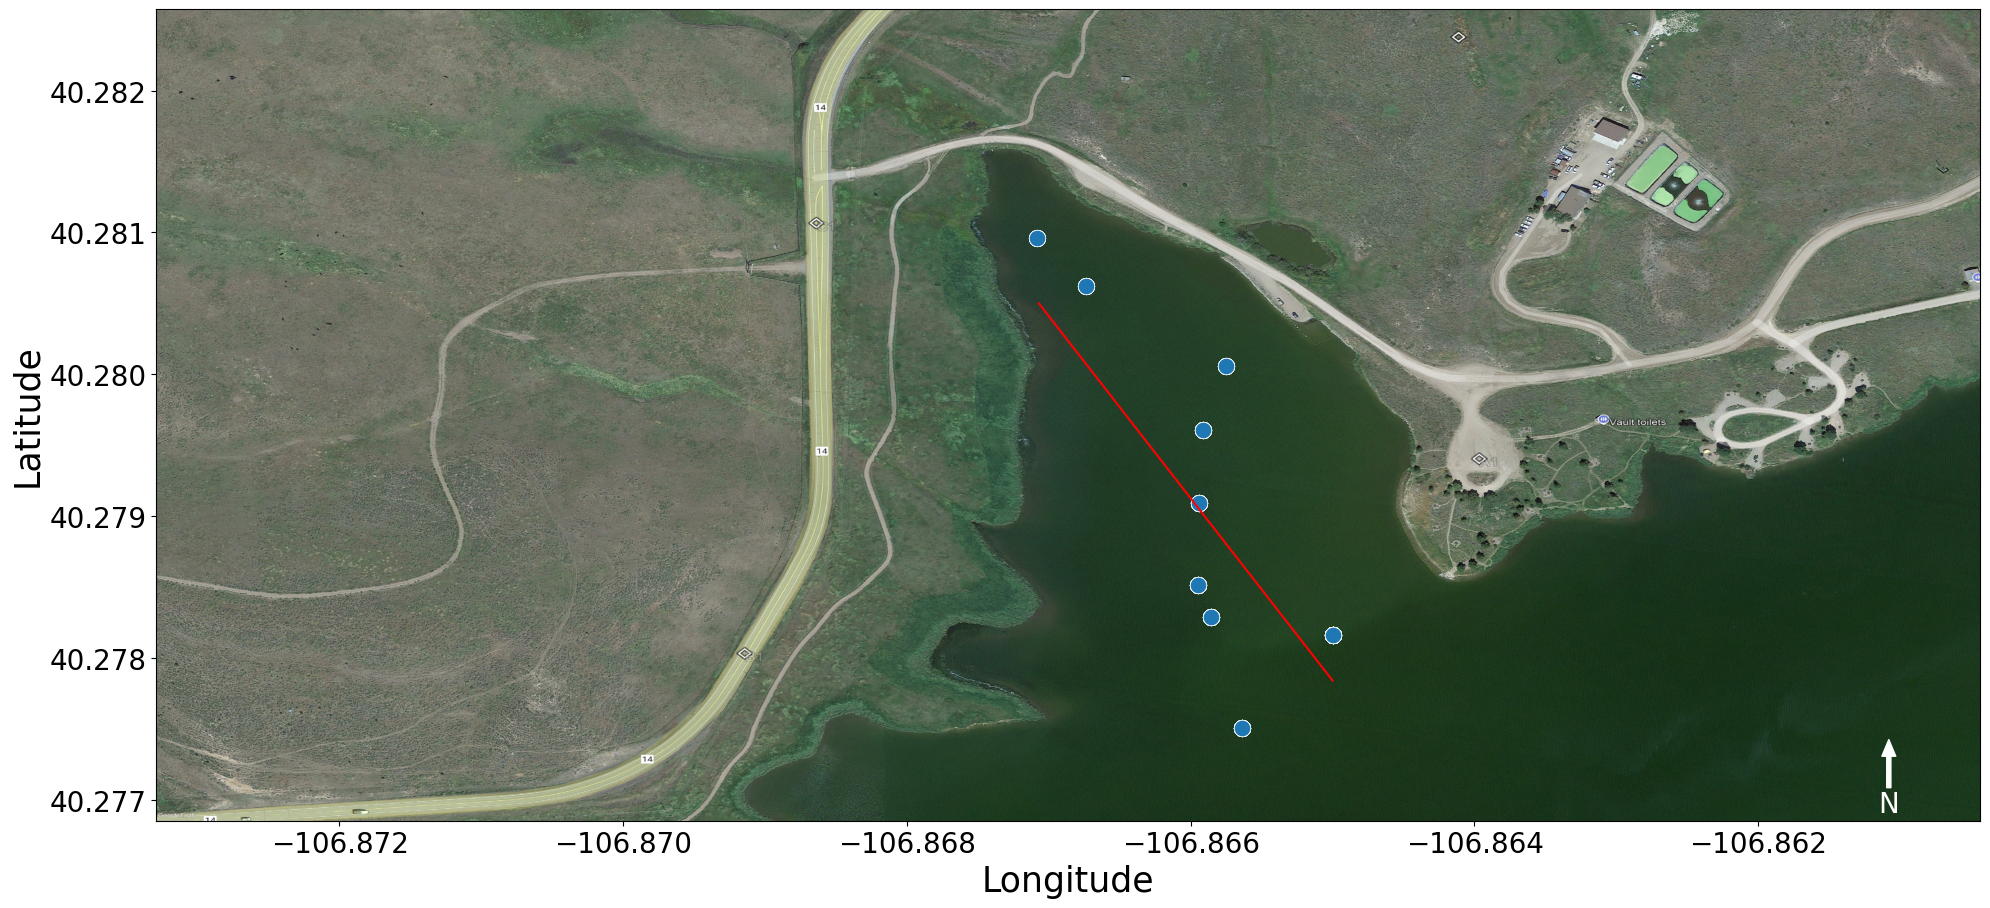

In [36]:
fig, ax = plt.subplots(figsize=(20, 20))

show(tif_keystone, ax=ax)

sc = ax.scatter(
    KEY_18['Longitude'],
    KEY_18['Latitude'],
    s=140,
    edgecolor='white',
    linewidth=0.5
)

divider = make_axes_locatable(ax)

ax.set_xlabel("Longitude", fontsize=25)
ax.set_ylabel("Latitude", fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=20)

# north arrow
ax.annotate(
    'N',
    xy=(0.95, 0.10),
    xytext=(0.95, 0.02),
    arrowprops=dict(
        facecolor='white',
        edgecolor='white',
        width=3,
        headwidth=10
    ),
    color='white',
    ha='center',
    va='center',
    fontsize=20,
    xycoords='axes fraction'
)
plt.plot(x,y,color='red')

ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
ax.xaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.tight_layout()
plt.show()

In [37]:
# find unique casts from keystone on the 18th
casts = KEY_18[['File Name', 'Easting', 'Northing']].drop_duplicates().reset_index(drop=True)

# find best fit line for transect with easting and northing
m, b = np.polyfit(casts['Easting'], casts['Northing'], 1)
# unit direction vector along that line
v = np.array([1.0, m])
v_unit = v / np.linalg.norm(v)
# choose a reference point on the line (when Easting=0 → Northing=b)
p0 = np.array([0.0, b])

# Project each cast onto the line:
# s_i = (p_i - p0) ⋅ v_unit   → distance along line in meters
XY = casts[['Easting', 'Northing']].to_numpy()
s_m = (XY - p0) @ v_unit
casts['distance_m'] = s_m - s_m.min()

df_KEY = KEY_18.merge(casts[['File Name', 'distance_m']], on='File Name')

# for dashed lines
depth_at_1_35 = df_KEY.loc[np.isclose(df_KEY['Pressure (dbar)'], 1.35, atol=0.01), 'Depth (m)'].mean()
depth_at_015 = df_KEY.loc[np.isclose(df_KEY['Pressure (dbar)'], 0.15, atol=0.01), 'Depth (m)'].mean()
depth_at_4_95 = df_KEY.loc[np.isclose(df_KEY['Pressure (dbar)'], 4.95, atol=0.01), 'Depth (m)'].mean()


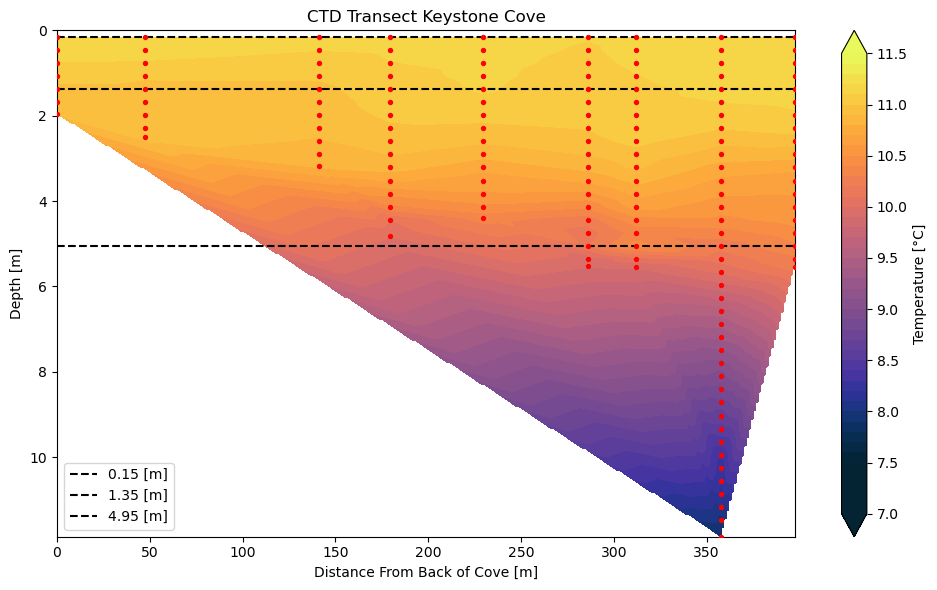

In [38]:
# create grid for distance from inlet and depth
dist_grid  = np.linspace(df_KEY.distance_m.min(), df_KEY.distance_m.max(),300)
depth_grid = np.linspace(0, df_KEY['Depth (m)'].max(),300)
# create mesh grid
D, Z = np.meshgrid(dist_grid, depth_grid)

# interpolate temperature
points = np.vstack((df_KEY.distance_m, df_KEY['Depth (m)'])).T
T = griddata(points, df_KEY['Temperature (°C)'], (D, Z), method='linear', fill_value=np.nan)

# plot
fig, ax = plt.subplots(figsize=(10, 6))
levels = np.arange(7.0, 11.51, 0.1)
cf = ax.contourf(D, Z, T, levels=levels, extend='both', vmin=7.5, vmax=11.5, cmap=cmo.thermal)
ax.scatter(df_KEY.distance_m, df_KEY['Depth (m)'], s=8, c='red', zorder=4)

ax.axhline(y=depth_at_015, color='black', linestyle='--', linewidth=1.5, label='0.15 [m]')
ax.axhline(y=depth_at_1_35, color='black', linestyle='--', linewidth=1.5, label='1.35 [m]')
ax.axhline(y=depth_at_4_95, color='black', linestyle='--', linewidth=1.5, label='4.95 [m]')

ax.legend()
ax.invert_yaxis()
ax.set_xlabel('Distance From Back of Cove [m]')
ax.set_ylabel('Depth [m]')
ax.set_title('CTD Transect Keystone Cove')
fig.colorbar(cf, ax=ax, label='Temperature [°C]')
plt.tight_layout()
plt.show()

- dashed line at 1.35 dbar
- 

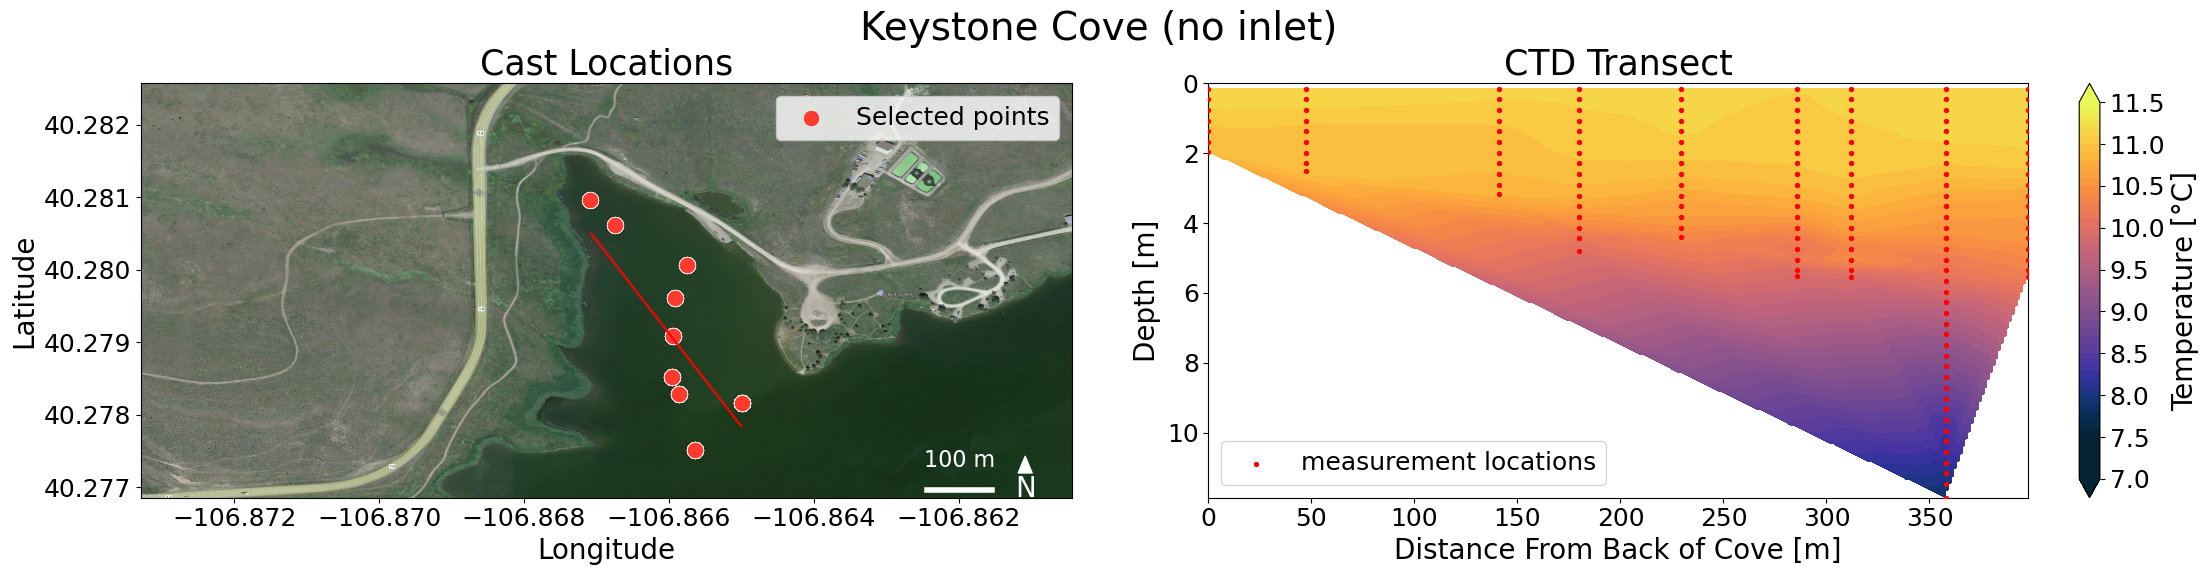

In [41]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(23, 6))

# CTD transcet
levels = np.arange(7, 11.51, 0.1)
cf = ax1.contourf(D, Z, T, levels=levels, extend='both', vmin=7.5, vmax=11.5, cmap=cmo.thermal)
ax1.scatter(df_KEY.distance_m, df_KEY['Depth (m)'], s=8, c='red', zorder=4, label = 'measurement locations')
ax1.invert_yaxis()
ax1.set_xlabel('Distance From Back of Cove [m]', fontsize=20)
ax1.set_ylabel('Depth [m]', fontsize=20)
ax1.set_title('CTD Transect', fontsize=25)
#ax1.legend(fontsize=12, loc='lower left')
ax1.legend(fontsize=18, loc='best')
ax1.tick_params(axis='both', labelsize=18)
cbar1 = fig.colorbar(cf, ax=ax1)
cbar1.ax.tick_params(labelsize=18)
cbar1.set_label('Temperature [°C]', fontsize=20)

#map with points
show(tif_keystone, ax=ax2)

ax2.scatter(
    KEY_18['Longitude'], KEY_18['Latitude'],
    s=140, facecolor='#FF3B30', edgecolor='white', linewidth=0.5,
    label='Selected points'
)

# North arrow
ax2.annotate(
    'N', xy=(0.95, 0.10), xytext=(0.95, 0.02),
    arrowprops=dict(facecolor='white', edgecolor='white', width=3, headwidth=10),
    color='white', ha='center', va='center', fontsize=20,
    xycoords='axes fraction'
)

# 100 m scale bar (longitude degrees at ~40°N)
scale_deg = 0.000899  # ≈ 100 meters

# Get current axis limits
xlim = ax2.get_xlim()
ylim = ax2.get_ylim()

# Define scale bar position (bottom-right corner of map view)
x_start = xlim[1] - 0.002
x_end = x_start + scale_deg
y_pos = ylim[0] + 0.0001

# Draw scale bar
ax2.plot([x_start, x_end], [y_pos, y_pos], color='white', linewidth=4, zorder=10)

# Add "100 m" label above the scale bar
ax2.text((x_start + x_end) / 2, y_pos + 0.00025, '100 m',
         ha='center', va='bottom', fontsize=16, color='white', zorder=10)

ax2.plot(x, y, color='red')


ax2.set_xlabel('Longitude', fontsize=20)
ax2.set_ylabel('Latitude', fontsize=20)
ax2.tick_params(axis='both', labelsize=18)
ax2.set_title('Cast Locations', fontsize=25)
ax2.legend(fontsize=18, loc='upper right')

ax2.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
ax2.xaxis.get_major_formatter().set_useOffset(False)

ax2.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
ax2.yaxis.get_major_formatter().set_useOffset(False)
plt.suptitle("Keystone Cove (no inlet)", fontsize=28, y=.95)
plt.tight_layout()
plt.show()
